In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
import pyreadr as pr
import math
import copy

In [2]:
loader = pr.read_r("saudi_met_df.Rdata")
cov = loader['met.df.saudi'].to_numpy()
print(loader.keys())
loader = pr.read_r("saudi_lc_df.Rdata")
cov22 = loader['lc.df.saudi'].to_numpy()
names = loader['lc.names.saudi']
print(loader.keys())

odict_keys(['met.df.saudi', 'met.df.names'])
odict_keys(['lc.df.saudi', 'lc.names.saudi'])


In [3]:
loc_df = pd.read_csv("loc.csv")
alt_df = pd.read_csv("oredf.csv")
data_df = pd.read_csv("data.csv")

In [4]:
nan_loc = np.argwhere(np.isnan(cov[0,:,0]))
for ind in reversed(nan_loc.tolist()):
    loc_df = loc_df.drop(labels=ind)
    alt_df = alt_df.drop(labels=ind)
    data_df = data_df.drop(columns=data_df.columns[ind])
    cov = np.concatenate((cov[:,0:ind[0],:],cov[:,ind[0]+1:,:]),axis=1)
    cov22 = np.concatenate((cov22[0:ind[0],:,:],cov22[ind[0]+1:,:,:]),axis=0)
print(sum(sum(sum(np.isnan(cov)))))

0


In [5]:
print(cov.shape)
cov =cov[:,:,[0,1,3,4,5,6,7,8,9]]
print(cov.shape)

(276, 17091, 10)
(276, 17091, 9)


In [6]:
cov1=torch.tensor(cov,dtype=torch.float32)
cov1 = torch.transpose(cov1,dim0=0,dim1=1)

cov2= torch.tensor(loc_df.values,dtype=torch.float32)
cov2= cov2.repeat(276,1,1)
cov2 = torch.transpose(cov2,dim0=0,dim1=1)
cov3= torch.tensor(alt_df.values,dtype=torch.float32)
cov3= cov3.repeat(276,1,1)
cov3 = torch.transpose(cov3,dim0=0,dim1=1)
cov4 = torch.arange(0,276).repeat(cov3.shape[0],1,1)
cov4 = torch.transpose(cov4,dim0=1,dim1=2)
cov5 = torch.tensor(cov22,dtype=torch.float32)

yt= torch.tensor(data_df.values,dtype=torch.float32)
yt = torch.transpose(yt,dim0=0,dim1=1)
yt = torch.unsqueeze(yt,2)

all_cov = torch.cat((cov1,cov2,cov3,cov4,cov5),axis=2)
mean = all_cov.mean(dim = (0,1))
std = all_cov.std(dim = (0,1))
all_cov = (all_cov - mean)/std
print(all_cov.shape,yt.shape)

torch.Size([17091, 276, 36]) torch.Size([17091, 276, 1])


In [7]:
class pm2_data(Dataset):
    def __init__(self):
        self.x = all_cov
        self.y = yt
    
    def __len__(self):
        return self.y.shape[0]
   
    def __getitem__(self,ind):
        return self.x[ind,:,:],self.y[ind,:]

data_set = pm2_data()
tr_n = int(0.8 * len(data_set))
test_n = len(data_set) - tr_n
train_set, test_set = random_split(data_set, [tr_n, test_n])

In [8]:
train_loader=DataLoader(train_set,batch_size=5500,shuffle=True,drop_last=True)
test_loader =DataLoader(test_set,batch_size=5500,shuffle=False)

In [9]:
def Quantile_loss(y_pred,y_true):
    return torch.mean(torch.maximum(0.90*(y_true-y_pred),-0.1*(y_true-y_pred)))

In [10]:
class extrmv_nn(nn.Module):
    def __init__(self, n_input=36, n_output=1):
        super().__init__()
        self.fc1 = nn.Linear(n_input,16)
        self.fc2 = nn.Linear(16,14)
        self.fc3 = nn.Linear(14,20)
        self.out = nn.Linear(20, n_output)
        self.out.weight.data = torch.zeros(self.out.weight.data.shape)
        self.out.bias.data[0] = 111

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = extrmv_nn()
model.to(device)
lr = 0.002
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

cuda


In [12]:
epochs = 800
train_loss = []
test_loss = []
best_loss = 10**10
for e in range(epochs):
    running_loss = 0
    for i, (data, true_output) in enumerate(train_loader):
        data = data.to(device)
        true_output = true_output.to(device)
        optimizer.zero_grad() #Sets the gradients of all optimized tensors to zero
        output = model(data) 
        loss = Quantile_loss(output, true_output) #calculate the loss 
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()
    
    
    train_loss.append(running_loss)
    print("Epoch {} - Training loss: {}".format(e, running_loss))
    
    running_loss = 0
    for i, (data, true_output) in enumerate(test_loader):
        data = data.to(device)
        true_output = true_output.to(device)
        output = model(data) 
        loss = Quantile_loss(output, true_output)
        running_loss += loss.item()
    if (running_loss<=best_loss):
        best_loss = running_loss
        best_model = copy.deepcopy(model)
        
    test_loss.append(running_loss)
    print("Epoch {} - Testing loss: {}".format(e, running_loss))

Epoch 0 - Training loss: 10.90008544921875
Epoch 0 - Testing loss: 5.434291839599609
Epoch 1 - Training loss: 10.871844291687012
Epoch 1 - Testing loss: 5.433627128601074
Epoch 2 - Training loss: 10.853989601135254
Epoch 2 - Testing loss: 5.432884693145752
Epoch 3 - Training loss: 10.887305736541748
Epoch 3 - Testing loss: 5.432045936584473
Epoch 4 - Training loss: 10.868418216705322
Epoch 4 - Testing loss: 5.431090354919434
Epoch 5 - Training loss: 10.875207424163818
Epoch 5 - Testing loss: 5.429991722106934
Epoch 6 - Training loss: 10.887739181518555
Epoch 6 - Testing loss: 5.428721904754639
Epoch 7 - Training loss: 10.883212566375732
Epoch 7 - Testing loss: 5.427242279052734
Epoch 8 - Training loss: 10.86806869506836
Epoch 8 - Testing loss: 5.425505638122559
Epoch 9 - Training loss: 10.858276844024658
Epoch 9 - Testing loss: 5.423442840576172
Epoch 10 - Training loss: 10.888422012329102
Epoch 10 - Testing loss: 5.420965671539307
Epoch 11 - Training loss: 10.861836433410645
Epoch 11 

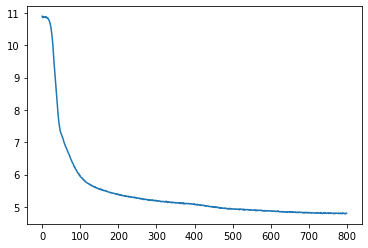

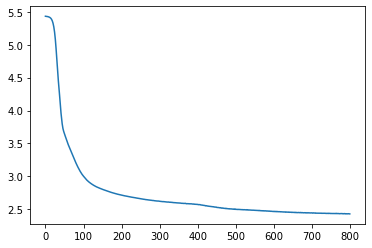

In [13]:
plt.plot(np.arange(epochs),train_loss)
plt.show()
plt.plot(np.arange(epochs),test_loss)
plt.show()



In [12]:
PATH = './quantile22.pth'
#torch.save(best_model.state_dict(), PATH)

In [13]:
model = extrmv_nn()
model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
best_model = extrmv_nn()
best_model.to(device)
best_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([17091, 276, 1])


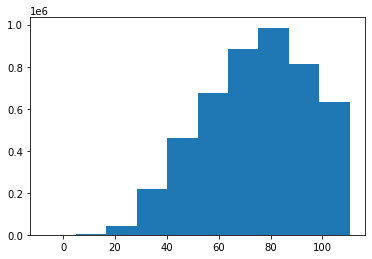

In [14]:
threshold1 = best_model(all_cov[:10000,:,:].to(device)).cpu().detach()
threshold2 = best_model(all_cov[10000:,:,:].to(device)).cpu().detach()
threshold = torch.cat((threshold1,threshold2),axis=0)
print(threshold.shape)
plt.hist(torch.reshape(threshold,(-1,)).numpy())
plt.show()

In [15]:
y = yt - threshold
y = torch.reshape(y,(-1,))
all_cov = torch.reshape(all_cov,(-1,36))
index = (y >0).nonzero().squeeze()
print(index.shape,yt.shape,y.shape)


torch.Size([522596]) torch.Size([17091, 276, 1]) torch.Size([4717116])


In [17]:
y_q = y[index]
all_cov_q = all_cov[index,:] 
y_q = y_q.reshape((130649,4))
all_cov_q = all_cov_q.reshape((130649,4,36))
print(y_q.shape,all_cov_q.shape)

torch.Size([130649, 4]) torch.Size([130649, 4, 36])


In [18]:
class pm2_data(Dataset):
    def __init__(self):
        self.x = all_cov_q
        self.y = y_q
    
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,ind):
        return self.x[ind,:],self.y[ind]

data_set = pm2_data()
tr_n = int(0.8 * len(data_set))
test_n = len(data_set) - tr_n
train_set, test_set = random_split(data_set, [tr_n, test_n])

In [19]:
train_loader=DataLoader(train_set,batch_size=6925,shuffle=True,drop_last=True)
test_loader =DataLoader(test_set,batch_size=1730,shuffle=False,drop_last=True)

In [20]:
def GPD_NLLL(y_pred,y_true):# negative log liklihood loss for GPD
    scale = y_pred[:,:,0]
    shape = y_pred[:,:,1]
    y_true = y_true.squeeze()
    loss = torch.sum(torch.log(scale) + (1 + 1/shape) * torch.log( 1 + shape*y_true/scale))
    return loss

In [21]:
class scale_nn(nn.Module):
    def __init__(self, n_input=36, n_output=1):
        super().__init__()
        self.fc1 = nn.Linear(n_input,20)
        self.fc2 = nn.Linear(20,14)
        self.fc3 = nn.Linear(14,16)
        self.out = nn.Linear(16, n_output)
        self.out.weight.data = torch.zeros(self.out.weight.data.shape)
        self.out.bias.data[0] = 1.8

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        x = torch.exp(x)
        return x

In [22]:
class shape_nn(nn.Module):
    def __init__(self, n_input=1, n_output=1):
        super().__init__()
        self.out = nn.Linear(n_input, n_output)
        self.out.bias.data[0] = 0.9

    def forward(self, x):
        x = self.out(x)
        return x

In [23]:
shape_n = shape_nn()
scale_n = scale_nn()

#shape_n = shape_n.to(device)
#scale_n =scale_n.to(device)
lr = 0.003
params = list(shape_n.parameters()) + list(scale_n.parameters())
optimizer = optim.Adam(params, lr=lr, weight_decay=0.0001)

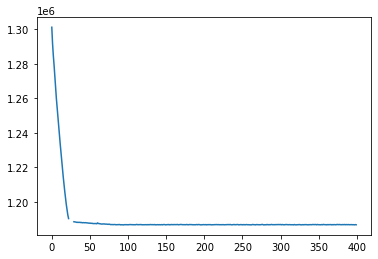

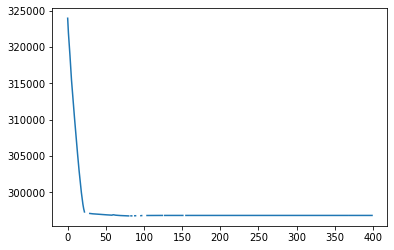

In [25]:
plt.plot(np.arange(epochs),train_loss)
plt.show()
plt.plot(np.arange(epochs),test_loss)
plt.show()


In [26]:
shape = best_shape(torch.zeros((data.shape[0],data.shape[1],1)))
scale = best_scale(data)
print(shape[1:5,1],scale[1:5,1])

tensor([[-0.1273],
        [-0.1273],
        [-0.1273],
        [-0.1273]], grad_fn=<SelectBackward0>) tensor([[ 5.5899],
        [ 5.2776],
        [ 4.7271],
        [13.1606]], grad_fn=<SelectBackward0>)


In [27]:
def GPD_cdf(y,scale,shape):
    return 1-(1+shape*y/scale)**(-1/shape)

tensor(8.2409)
tensor(-0.1273)
tensor(5.1562)


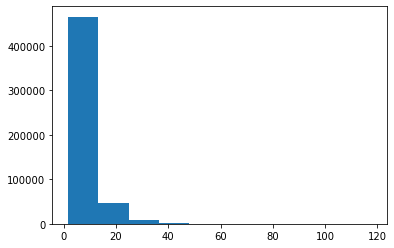

In [28]:
scale = best_scale(all_cov_q).detach().reshape((-1,))
shape = best_shape(torch.zeros(1)).detach()
print(scale.mean())
print(shape.mean())
print(scale.std())
plt.hist(scale.numpy())
plt.show()
ve = GPD_cdf(y_q.reshape((-1,)),scale,shape)
exquan = -torch.log(1-ve)
exquan = torch.quantile(exquan,torch.arange(0.01,1,0.001))

8.240860939025879 -0.12730003893375397
torch.Size([522596])


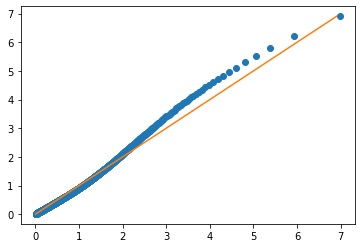

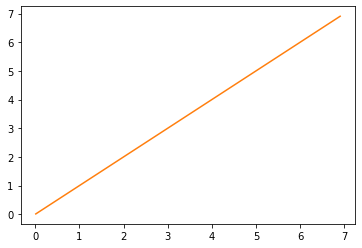

In [29]:
the_q = -np.log(1-np.arange(0.01,1,0.001))
print(scale.mean().item(),shape.mean().item())
print(y_q.reshape((-1,)).shape)
ve = GPD_cdf(y_q.reshape((-1,)),scale.mean(),shape.mean())
guss = -torch.log(1-ve)
guss = torch.quantile(guss,torch.arange(0.01,1,0.001))

plt.figure("the gpd fit")
plt.plot(exquan.numpy(),the_q,'o')
plt.plot(the_q,the_q)
plt.show()
plt.figure("the guss fit")
plt.plot(guss.numpy(),the_q,'o')
plt.plot(the_q,the_q)
plt.show()

In [32]:
print(all_cov.shape)
all_cov = all_cov.reshape((-1,276,36))
yt = yt.reshape((-1,276,1))

torch.Size([17091, 276, 36])


torch.Size([17091])


(array([ 339., 1214., 1436., 1620., 2505., 3071., 4673., 2154.,   72.,
           7.]),
 array([ 13.786888,  23.281624,  32.77636 ,  42.27109 ,  51.765827,
         61.260563,  70.755295,  80.25003 ,  89.74477 ,  99.2395  ,
        108.73424 ], dtype=float32),
 <BarContainer object of 10 artists>)

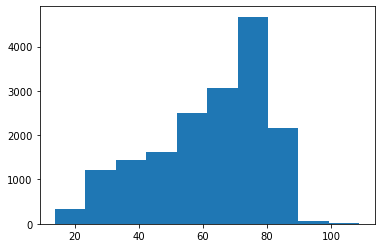

In [33]:
all_cov_v = all_cov[:,1,:]
y_v = yt[:,2,0].squeeze()
threshold_m1 = best_model(all_cov_v.to(device)).cpu().detach().squeeze()
print(threshold_m1.shape)
plt.hist(threshold_m1.numpy())


In [34]:
cov_loc = all_cov[1010,:,:]
y_loc = yt[1010,:]
print(cov_loc.shape)
threshold_loc = best_model(cov_loc.to(device)).cpu().detach().squeeze()
yq_loc = y_loc.squeeze() - threshold_loc
index = (yq_loc >0).nonzero().squeeze()
print(index.shape,yq_loc.shape,y_loc.shape,threshold_loc.shape,cov_loc_q.shape)
cov_loc_q =cov_loc[index,:]
print(index.shape,yq_loc.shape,y_loc.shape,threshold_loc.shape,cov_loc_q.shape)

torch.Size([276, 36])


NameError: name 'cov_loc_q' is not defined

In [158]:
print(sum(para.numel() for para in scale_n.parameters()))

1291


In [175]:
all_cov_v = all_cov[:,7*12+6,:]
threshold_m1 = best_model(all_cov_v.to(device)).cpu().detach().squeeze()
index = (threshold_m1 <u).nonzero().squeeze()
threshold_v = threshold_m1[index]
all_cov_vt = all_cov_v[index,:]
scale_v = best_scale(all_cov_vt).detach().reshape((-1,))
shape_v = best_shape(torch.zeros(1)).detach()
prob = 1 - GPD_cdf(u - threshold_v ,scale_v,shape_v)
prob2005 = torch.nan_to_num(prob)

all_cov_v = all_cov[:,17*12+6,:]
threshold_m1 = best_model(all_cov_v.to(device)).cpu().detach().squeeze()
index = (threshold_m1 <u).nonzero().squeeze()
threshold_v = threshold_m1[index]
all_cov_vt = all_cov_v[index,:]
scale_v = best_scale(all_cov_vt).detach().reshape((-1,))
shape_v = best_shape(torch.zeros(1)).detach()
prob = 1 - GPD_cdf(u - threshold_v ,scale_v,shape_v)
prob2015 = torch.nan_to_num(prob)

loc = cov2[:,0,:].squeeze()
print(loc.shape,prob2005.shape, prob2015.shape)
array = torch.cat((loc,prob2005.reshape((-1,1)),prob2015.reshape(-1,1)),axis =1)
print(array.shape)
df = pd.DataFrame(array.numpy(), columns = ['longitude','latitude','july2005','july2015'])
df.to_csv('psoter_plot_data.csv')

torch.Size([17091, 2]) torch.Size([17091]) torch.Size([17091])
torch.Size([17091, 4])


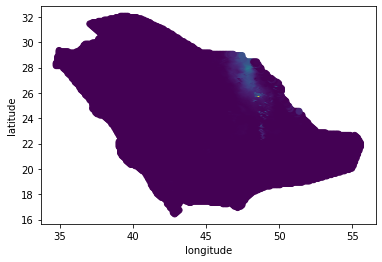

1998 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


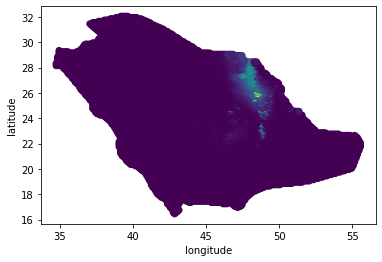

1999 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


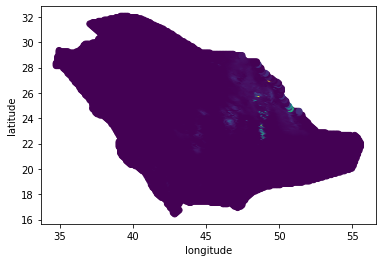

2000 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


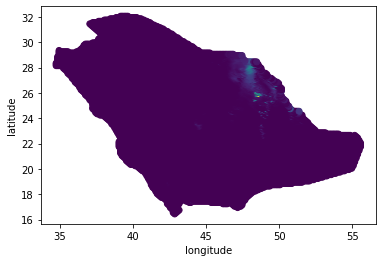

2001 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


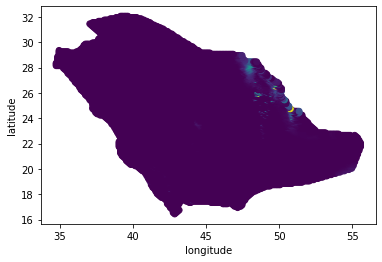

2002 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


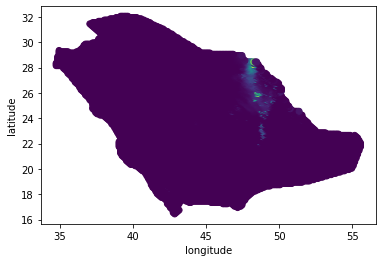

2003 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


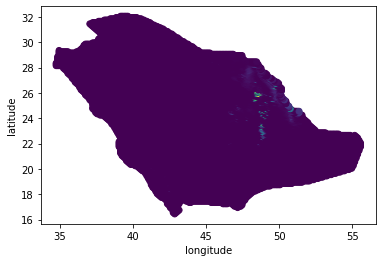

2004 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


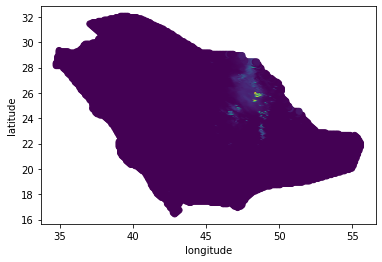

2005 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


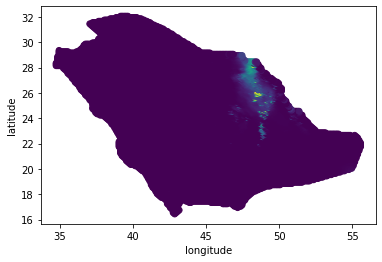

2006 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


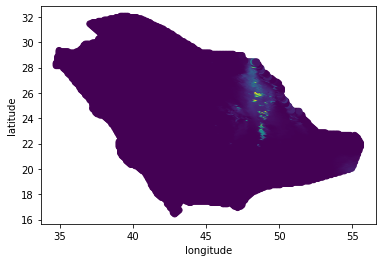

2007 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


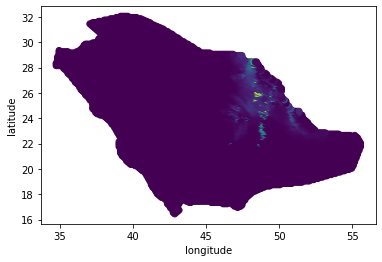

2008 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


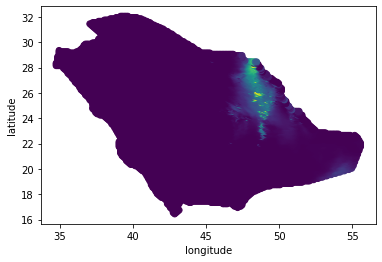

2009 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


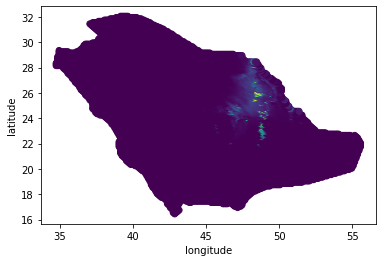

2010 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


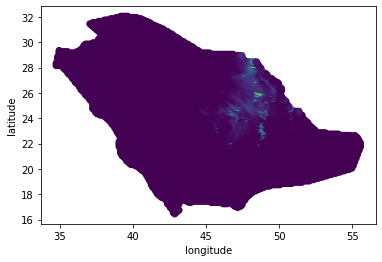

2011 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


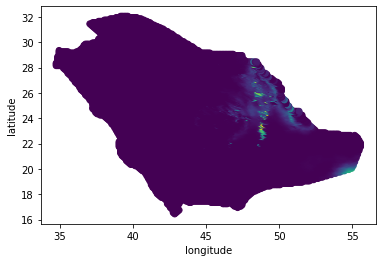

2012 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


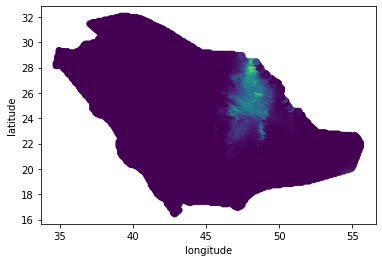

2013 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


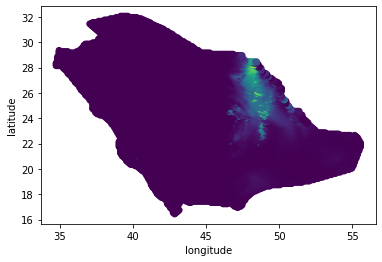

2014 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


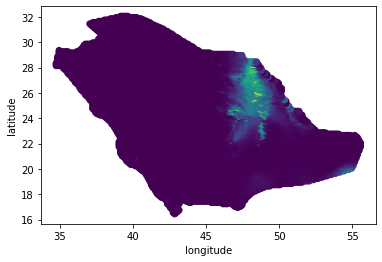

2015 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


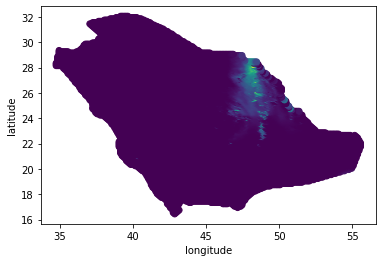

2016 torch.Size([17091, 276, 2]) torch.Size([17091, 36])


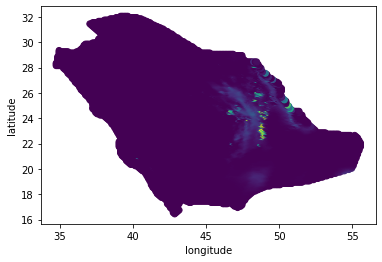

2017 torch.Size([17091, 276, 2]) torch.Size([17091, 36])
torch.Size([17091, 276, 2])


In [160]:
u = 150.4
for i in range(20):
    all_cov_v = all_cov[:,i*12+6,:]
    threshold_m1 = best_model(all_cov_v.to(device)).cpu().detach().squeeze()
    index = (threshold_m1 <u).nonzero().squeeze()
    threshold_v = threshold_m1[index]
    all_cov_vt = all_cov_v[index,:]
    scale_v = best_scale(all_cov_vt).detach().reshape((-1,))
    shape_v = best_shape(torch.zeros(1)).detach()
    prob = 1 - GPD_cdf(u - threshold_v ,scale_v,shape_v)
    prob = torch.nan_to_num(prob)
    plt.scatter(cov2[:,0,0].numpy(),cov2[:,0,1].numpy(),c=prob.numpy())
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()
    print(i+1998 ,cov2.shape,all_cov_vt.shape)

print(cov2.shape)

In [ ]:
for i in range(36):
    print(i,best_scale.fc1.weight.data[:,i].abs().mean())

0 tensor(0.1691)
1 tensor(0.1361)
2 tensor(0.3141)
3 tensor(0.1841)
4 tensor(0.1649)
5 tensor(0.1814)
6 tensor(0.2049)
7 tensor(0.2393)
8 tensor(0.2430)
9 tensor(0.2530)
10 tensor(0.1649)
11 tensor(0.1611)
12 tensor(0.0887)
13 tensor(0.2468)
14 tensor(0.0585)
15 tensor(0.0770)
16 tensor(0.1253)
17 tensor(0.0861)
18 tensor(0.1214)
19 tensor(0.1063)
20 tensor(0.1308)
21 tensor(0.1654)
22 tensor(0.1651)
23 tensor(0.1185)
24 tensor(0.1172)
25 tensor(0.1078)
26 tensor(0.1017)
27 tensor(0.1860)
28 tensor(0.0897)
29 tensor(0.1270)
30 tensor(0.0943)
31 tensor(0.1562)
32 tensor(0.1258)
33 tensor(0.0611)
34 tensor(0.1378)
35 tensor(0.1158)


(array([3.54446e+05, 8.24710e+04, 1.76310e+04, 3.96000e+03, 1.32300e+03,
        4.17000e+02, 7.60000e+01, 1.90000e+01, 1.00000e+01, 5.00000e+00]),
 array([3.0517578e-05, 8.9691715e+00, 1.7938313e+01, 2.6907452e+01,
        3.5876595e+01, 4.4845734e+01, 5.3814873e+01, 6.2784016e+01,
        7.1753159e+01, 8.0722298e+01, 8.9691437e+01], dtype=float32),
 <BarContainer object of 10 artists>)

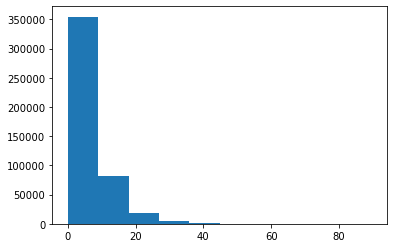

In [ ]:
plt.hist(y_q.reshape((-1,)).numpy())

In [35]:
cities = {"Dammam":torch.tensor([50.15,26.45]),"Riyadh":torch.tensor([46.75,24.85]),"Jeddah":torch.tensor([39.25,21.65])}
cities = {"Riyadh":torch.tensor([46.75,24.85]),"KAUST":torch.tensor([39.11,22.3]),"Jubail":torch.tensor([49.58,27.0])}
cities = {"Riyadh":torch.tensor([46.75,24.85]),"NEOM":torch.tensor([35.10,28.11]),"Jubail":torch.tensor([49.58,27.0])}
cities = {"Riyadh":torch.tensor([46.75,24.85]),"Jubail":torch.tensor([49.58,27.0]),"Hafuf":torch.tensor([49.57,25.37])}

In [129]:
cities = {"Riyadh":torch.tensor([46.75,24.85]),"Jubail":torch.tensor([49.58,27.0]),"Hafuf":torch.tensor([49.57,25.37])}
loc_ind = {city:[] for city in cities}
for city in cities:
    loc_ind[city] = torch.argmin((cov2[:,0,:]-cities[city]).abs().sum(dim=1)) .item()

print(loc_ind)

{'Riyadh': 9799, 'Jubail': 12821, 'Hafuf': 10497}


In [130]:
u = 150.4
city_th = { x: best_model(all_cov[loc_ind[x],:,:].to(device)).cpu().detach().squeeze() for x in loc_ind }
city_scale = {x:best_scale(all_cov[loc_ind[x],:,:]).detach().reshape(-1,) for x in loc_ind }
shape_v = best_shape(torch.zeros(1)).detach()
city_prob = {x:np.arange(276, dtype='float') for x in loc_ind}
for city in city_th:
    temp = np.arange(276,dtype='float')
    for i in range(len(city_th[city])):
        if city_th[city][i]<u:
            prob = GPD_cdf(u - city_th[city][i] ,city_scale[city][i],shape_v)
            temp[i] = torch.nan_to_num(1-prob).numpy()*0.1
        else:
            temp[i] = 0.1
    city_prob[city] = temp
            

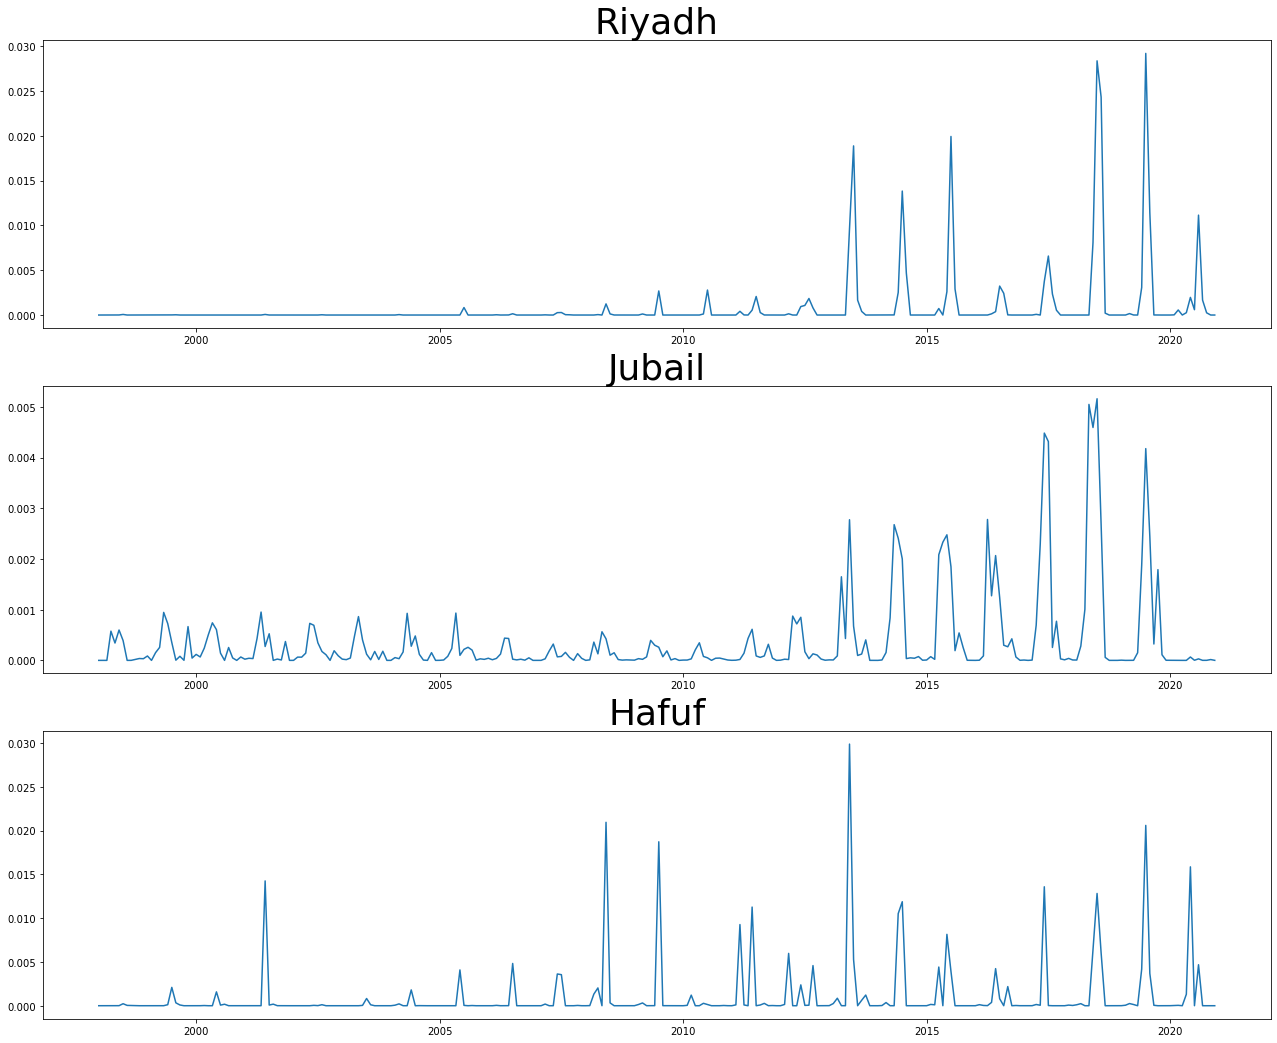

In [131]:
i= 1
plt.figure(figsize=(22, 18))
for city in cities:
    plt.subplot(len(cities),1,i)
    plt.title(city,fontsize=36)
    plt.plot(1998+ np.arange(276)/12,city_prob[city])
    i=i+1
plt.show()